In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import keras
from keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt
from google.cloud import bigquery

In [2]:
client = bigquery.Client()
dollar_bars = client.query(
    """
  SELECT date, open, high, low, close, volume FROM chemackana-project.ticks_test.ETH_DOLLAR_BARS"""
  ).to_dataframe()

In [3]:
dollar_bars.set_index("date", inplace = True)
dollar_bars = dollar_bars.sort_index()

In [4]:
dollar_bars

,open,high,low,close,volume
date,,,,,
2019-01-01 13:56:06,130.66000,143.440000,129.50,140.84000,297439.939532
2019-01-01 21:07:24,140.85000,148.151924,130.82,138.42000,289159.297022
2019-01-02 07:20:22,144.41000,149.400000,135.06,142.63999,283370.320293
2019-01-02 12:57:18,142.63999,155.810000,142.49,148.63000,269910.837161
2019-01-02 16:54:26,148.17000,160.820000,147.43,157.60000,262522.102513
...,...,...,...,...,...
2021-06-06 13:19:42,2708.34000,2729.030000,2666.21,2666.80000,14981.312446
2021-06-06 15:20:21,2667.50000,2733.960000,2653.30,2720.88000,15021.305206
2021-06-06 17:54:04,2720.14000,2738.570553,2683.94,2694.65000,14891.130212


In [5]:
close_data = dollar_bars['close'].values
close_data = close_data.reshape((-1,1))

split_percent_oot = 0.90
split_percent_oob = 0.80
split_1 = int(split_percent_oot*len(close_data))


close_train = close_data[:split_1]
close_test_oot = close_data[split_1:]
split_2 = int(split_percent_oob*len(close_train))
close_train = close_data[:split_2]
close_test_oob = close_data[split_2:split_1]

date_train = dollar_bars.index[:split_2]
date_test_oob = dollar_bars.index[split_2:split_1]
date_test_oot = dollar_bars.index[split_1:]

print(len(close_train))
print(len(close_test_oob))
print(len(close_test_oot))

7574
1894
1052


In [6]:
look_back = 15

train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=20)     
test_generator = TimeseriesGenerator(close_test_oob, close_test_oob, length=look_back, batch_size=1)

In [7]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential()
model.add(
    LSTM(10,
        activation='relu',
        input_shape=(look_back,1))
)
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

num_epochs = 100
model.fit_generator(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/100


/opt/conda/miniconda3/lib/python3.8/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


378/378 [==============================] - 21s 6ms/step - loss: 1459441.2705
Epoch 2/100
378/378 [==============================] - 2s 6ms/step - loss: 1621770.6954
Epoch 3/100
378/378 [==============================] - 2s 6ms/step - loss: 1798270.7688
Epoch 4/100
378/378 [==============================] - 2s 6ms/step - loss: 1687284.1906
Epoch 5/100
378/378 [==============================] - 2s 6ms/step - loss: 1666871.3881
Epoch 6/100
378/378 [==============================] - 2s 6ms/step - loss: 1626393.2652
Epoch 7/100
378/378 [==============================] - 2s 6ms/step - loss: 1520227.0724
Epoch 8/100
378/378 [==============================] - 2s 6ms/step - loss: 1655171.4612
Epoch 9/100
378/378 [==============================] - 2s 6ms/step - loss: 1689084.5137
Epoch 10/100
378/378 [==============================] - 2s 6ms/step - loss: 1755025.0313
Epoch 11/100
378/378 [==============================] - 2s 6ms/step - loss: 1739919.5987
Epoch 12/100
378/378 [===================

In [8]:
preds=model.predict(test_generator)

In [9]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(preds, close_test_oob[15:])

53.013451907711215

In [10]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)

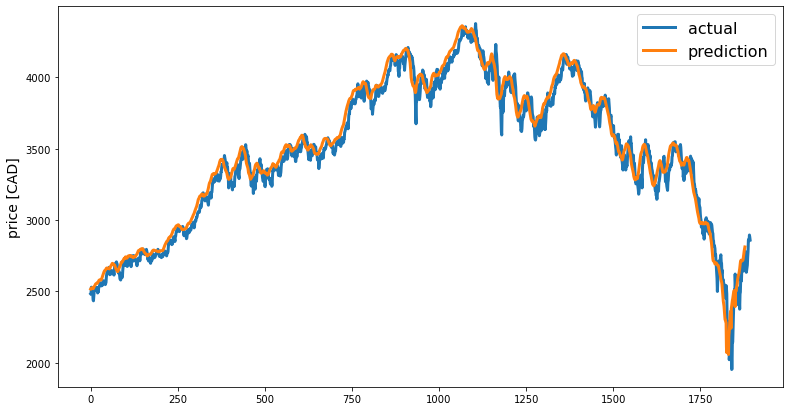

In [11]:
line_plot(close_test_oob, preds, 'actual', 'prediction', lw=3)

In [12]:
test_generator_oot = TimeseriesGenerator(close_test_oot, close_test_oot, length=look_back, batch_size=1)

In [13]:
preds_oot=model.predict(test_generator_oot)

In [14]:
mean_absolute_error(preds_oot, close_test_oot[15:])

59.90406465063495

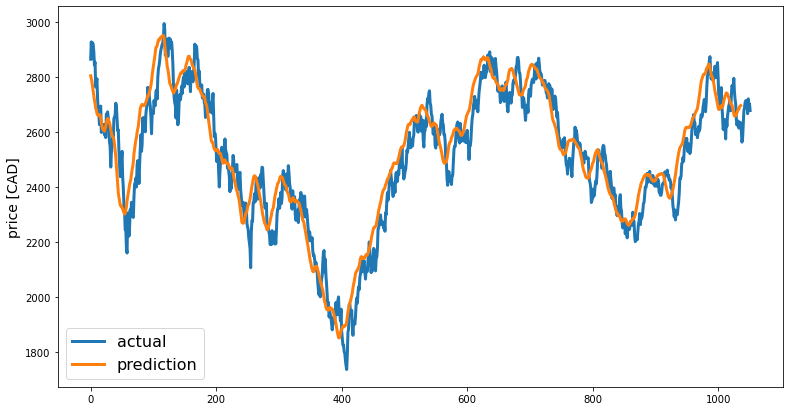

In [15]:
line_plot(close_test_oot, preds_oot, 'actual', 'prediction', lw=3)

In [16]:

close_data = close_data.reshape((-1))

def predict(num_prediction, model):
    prediction_list = close_data[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
    
def predict_dates(num_prediction):
    last_date = dollar_bars.index.values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = 500
forecast = predict(num_prediction, model)
forecast_dates = predict_dates(num_prediction)

In [17]:
oot_forecast=np.concatenate([preds_oot, forecast.reshape(501,1)])

In [18]:
len(close_test_oot)

1052

In [19]:
len(oot_forecast)

1538

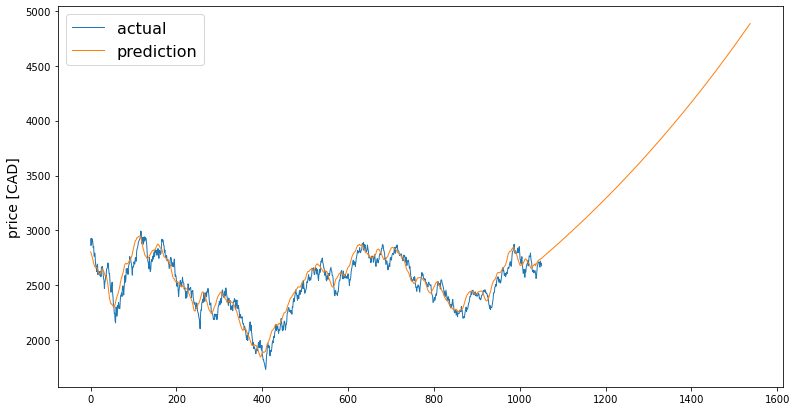

In [20]:
line_plot(close_test_oot, oot_forecast, 'actual', 'prediction', lw=1)

In [21]:
dollar_bars.index = pd.to_datetime(dollar_bars.index)

In [22]:
oot_df = pd.DataFrame({'date': date_test_oot, 'close': close_test_oot.reshape(-1)})

In [23]:
from datetime import timedelta, date

current_date = dollar_bars.index.max()
future_date = dollar_bars.index.max() + timedelta(days = 10)

start = pd.Timestamp(current_date)
end = pd.Timestamp(future_date)
t = np.linspace(start.value, end.value, 501)
t = pd.to_datetime(t)

In [24]:
forecast_df =  pd.DataFrame({'date': t, 'close': forecast})

In [25]:
res_df = pd.concat([oot_df[-100:],forecast_df])

In [26]:
#res_df.to_csv("/home/ts_model/eth_forecast.csv", index=False)

In [27]:
from google.cloud import storage
#@bucket_name: nombre del bucket
#@source_path: ruta al archivo local
#@destination_path: nombre del archivo como se va a guardar en bucket
def uploadToBucket(bucket_name, source_path, destination_path):
    try:
        client = storage.Client()
        bucket = client.get_bucket(bucket_name)
        blob = bucket.blob(destination_path)
        blob.upload_from_filename(source_path)

    except Exception as e:
        print("Error {er}".format(str(e)))


In [28]:
#uploadToBucket('bd_predictions','/home/ts_model/eth_forecast.csv','eth_forecast.csv')